
# Libraries



In [1]:
import numpy as np
import random
import pandas as pd
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
import seaborn as sns
import pandas as pd
from google.colab.patches import cv2_imshow
rcParams['figure.figsize'] = 20, 10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_curve,auc
from itertools import cycle

In [2]:
import os
print(os.listdir("./drive/MyDrive/CK+48"))

['happy', 'contempt', 'fear', 'surprise', 'sadness', 'anger', 'disgust']


# Extracting images from directory

In [3]:
data_path = './drive/MyDrive/CK+48'
data_dir_list = os.listdir(data_path)

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Succed to Load the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')

img_data = img_data/255
img_data.shape

Succed to Load the images of dataset-happy

Succed to Load the images of dataset-contempt

Succed to Load the images of dataset-fear

Succed to Load the images of dataset-surprise

Succed to Load the images of dataset-sadness

Succed to Load the images of dataset-anger

Succed to Load the images of dataset-disgust



(981, 48, 48, 3)

## Show examples of the import picture


## Show Examples of the Picture

We want to make sure that the photos are loaded sucessfully


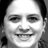

(48, 48, 3)
(48, 48, 3)


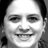

In [4]:
cv2_imshow(img_data_list[0])
print(img_data_list[0].shape)
print(img_data[0].shape)
cv2_imshow(img_data[0]*255)

# Putting label in data¶


In [5]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

index_to_labels = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabelByIndex(i):
    return index_to_labels[i]

# Dataset Overview

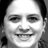

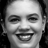

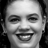

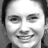

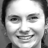

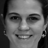

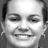

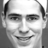

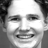

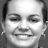

In [6]:
for i in range(10):
  cv2_imshow(img_data[i] * 255)


# Creating Model


In [7]:
def create_model(learning_rate):
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer= keras.optimizers.SGD(lr = learning_rate))
    
    return model


# Model Summary

In [8]:
learning_rate = 0.01

model_custom = create_model(learning_rate)
model_custom.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2416      
_________________________________________________________________
activation (Activation)      (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0

# Model Visualization 

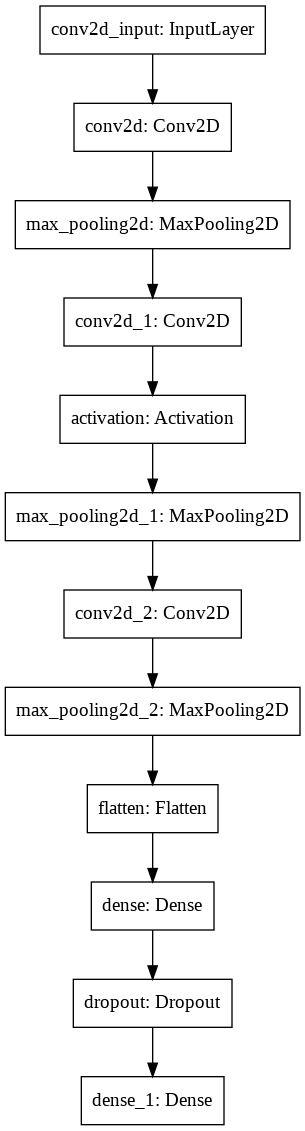

In [9]:
from keras.utils import plot_model
plot_model(model_custom, to_file='model.png')

# Training Model

In [10]:
learning_rate = 0.01
batch_size = 3
EPOCHS = 50
if not os.path.exists("model"):
  os.makedirs("model")


In [11]:
Y = np_utils.to_categorical(labels, num_classes)

x,y = shuffle(img_data,Y, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=2)

In [13]:
file_path = "./models/trained_model.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
early = EarlyStopping(monitor="loss", mode="min", patience=8)

callbacks_list = [checkpoint, early]

model = create_model(learning_rate)
hist = model.fit(X_train, y_train, batch_size = batch_size, epochs= EPOCHS, validation_data=(X_test, y_test), verbose=1)    
score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/50
196/196 [==============================] - 2s 6ms/step - loss: 1.9094 - accuracy: 0.1714 - val_loss: 1.8371 - val_accuracy: 0.3613
Epoch 2/50
196/196 [==============================] - 1s 5ms/step - loss: 1.8647 - accuracy: 0.2522 - val_loss: 1.7856 - val_accuracy: 0.4097
Epoch 3/50
196/196 [==============================] - 1s 5ms/step - loss: 1.7752 - accuracy: 0.3164 - val_loss: 1.6140 - val_accuracy: 0.5318
Epoch 4/50
196/196 [==============================] - 1s 5ms/step - loss: 1.5522 - accuracy: 0.4551 - val_loss: 1.2844 - val_accuracy: 0.5013
Epoch 5/50
196/196 [==============================] - 1s 5ms/step - loss: 1.4375 - accuracy: 0.4502 - val_loss: 1.2129 - val_accuracy: 0.5522
Epoch 6/50
196/196 [==============================] - 1s 5ms/step - loss: 1.1868 - accuracy: 0.5577 - val_loss: 1.1753 - val_accuracy: 0.4656
Epoch 7/50
196/196 [==============================] - 1s 5ms/step - loss: 1.1734 - accuracy: 0.5513 - val_loss: 1.0946 - val_accuracy: 0.5827
Epoch 

# Evaluating model


## Pick 10 random pictures and compare the predicted result with the expected *behavior*

In [ ]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

for i in range(20):
  index = random.randint(0, 200)
  cv2_imshow(X_test[index] * 255)
  test_image = X_test[index: index + 1]
  y_pred = best_model(test_image)
  print("predicted_label:"+ getLabelByIndex(np.argmax(y_pred, axis=1)[0]))

# Visualization

In [ ]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='eval_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='eval_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

#Model Save
best_model.save_weights('model_weights.h5')
best_model.save('model_keras.h5')

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
results = best_model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)

label_mapdisgust = ['anger','contempt','disgust','fear','happy','sadness','surprise']


#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )

final_cm = cm_df

plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

# ROC Curve

In [ ]:
final_label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
new_class = 7
y_pred = best_model.predict(X_test)
y_pred_ravel = y_pred.ravel()
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()